In [ ]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import PIL.Image as Img
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

from torchvision.datasets import CelebA
from torchvision.datasets import ImageFolder
import numpy as np
import glob

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# I have finished the free usage of google colab therefore i used CPU since my local machine has gtx 770
# therefore low number of epochs should be attributed to usage of CPU. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.display import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!unzip /content/drive/MyDrive/CelebA-0/CelebA/Img/img_align_celeba.zip

In [ ]:
device

device(type='cpu')

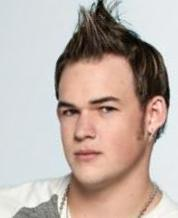

In [ ]:
#image = Img.open()
img = Image('/content/1/img_align_celeba/028768.jpg')
img

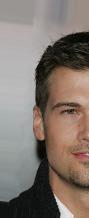

In [ ]:
#image = Img.open()
img = Image('/content/2/img_align_celeba/2.jpg')
img

In [ ]:
IMAGE_PATH = '/content/1/'


In [ ]:

seed = 60
batch_size = 64
new_image_size = 128
new_image_Size_cropped = (128, 64)
# manual seed to reproduce same results
torch.manual_seed(seed)

# normalize each image and set the pixel values between -1 and 1
img_transform = transforms.Compose([
    transforms.CenterCrop(new_image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])



In [ ]:
dataset = ImageFolder(IMAGE_PATH, img_transform)


In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: /content/1/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(128, 128))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=8, drop_last=True)

data_loader

In [ ]:
num = next(iter(data_loader_cropped))
test = num[0][0].size()
test

torch.Size([3, 128, 64])

In [ ]:
import torch.nn.functional as F


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # for converting 128 * 64 to 128*128 iamge
        self.fc1 = nn.Linear(2048, 16)
        self.fc2 = nn.Linear(16, 2048 * 2)

       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(-1,4,32,32)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))

        return x

model = ConvAutoencoder().to(device)


In [ ]:
class ConvAutoencoderv2(nn.Module):
    def __init__(self):
        super(ConvAutoencoderv2, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # for converting 128 * 64 to 128*128 iamge
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(16, 512 * 2)

       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 3, 2, stride=2)



    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = x.view(-1, 4, 16, 16)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
        x = F.sigmoid(self.t_conv3(x))
        return x

model_v2 = ConvAutoencoderv2().to(device)


In [ ]:
class simpleConvAutoencoder(nn.Module):
  def __init__(self):
    super(simpleConvAutoencoder, self).__init__()
    
    #Encoder
    self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  
    self.pool = nn.MaxPool2d(2, 2)
    
    # for converting 128 * 64 to 128*128 iamge
    self.fc1 = nn.Linear(65536, 256)
    self.fc2 = nn.Linear(256, 65536 * 2)

    
    #Decoder
    self.t_conv = nn.ConvTranspose2d(32, 3, 2, stride=2)



  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = torch.flatten(x, start_dim=1)
    x = self.fc1(x)
    x = self.fc2(x)
    x = x.view(-1, 32, 64, 64)
    #print(x.size())
    x = F.relu(self.t_conv(x))
    return x

simple_model = simpleConvAutoencoder().to(device)

In [ ]:
# tranining the simple model

optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
criterion = nn.MSELoss().to(device) 
n_epochs = 3
total_images = len(data_loader) * batch_size
total_lost_simple_model = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    batch_id = 0
    #Training
    for data in data_loader:
        images, _ = data
        images_cropped = images[:,:,:,:64]
        images = images.to(device)
        images_cropped = images_cropped.to(device)
        optimizer.zero_grad()
        outputs = simple_model(images_cropped)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if batch_id % 50 == 0:
          print(batch_id, 'batches computed')
        if batch_id > 500:
          break

        batch_id += 1

    train_loss = train_loss/len(data_loader)
    total_lost_simple_model.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 1 	Training Loss: 3.295175
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 2 	Training Loss: 3.295175
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 3 	Training Loss: 3.295175


In [ ]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

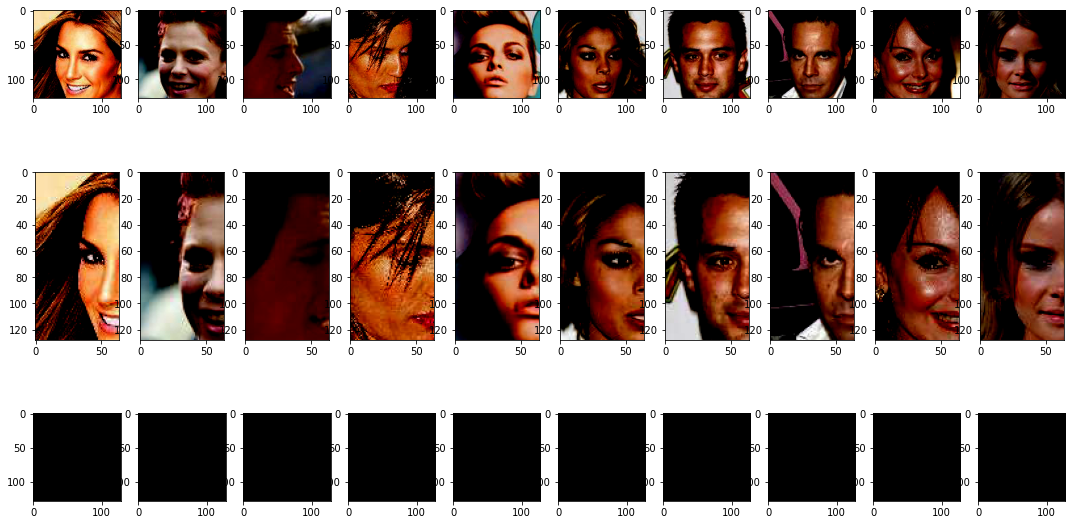

In [ ]:
num_actual = next(iter(data_loader))[0]

original_photos = num_actual
cropped_photos = original_photos[:,:,:,:64]

with torch.no_grad():

  output = simple_model(num_actual[:,:,:,:64].to(device))
  
fig, axes = plt.subplots(3, 10)

fig.set_size_inches(18.5, 10.5)

output = output.to(device)

axes[0][0].imshow(original_photos[0].permute(1, 2, 0))
axes[1][0].imshow(cropped_photos[0].permute(1, 2, 0))
axes[2][0].imshow(output[0].permute(1, 2, 0))

axes[0][1].imshow(original_photos[1].permute(1, 2, 0))
axes[1][1].imshow(cropped_photos[1].permute(1, 2, 0))
axes[2][1].imshow(output[1].permute(1, 2, 0))

axes[0][2].imshow(original_photos[2].permute(1, 2, 0))
axes[1][2].imshow(cropped_photos[2].permute(1, 2, 0))
axes[2][2].imshow(output[2].permute(1, 2, 0))

axes[0][3].imshow(original_photos[3].permute(1, 2, 0))
axes[1][3].imshow(cropped_photos[3].permute(1, 2, 0))
axes[2][3].imshow(output[3].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][5].imshow(original_photos[5].permute(1, 2, 0))
axes[1][5].imshow(cropped_photos[5].permute(1, 2, 0))
axes[2][5].imshow(output[5].permute(1, 2, 0))

axes[0][6].imshow(original_photos[6].permute(1, 2, 0))
axes[1][6].imshow(cropped_photos[6].permute(1, 2, 0))
axes[2][6].imshow(output[6].permute(1, 2, 0))

axes[0][7].imshow(original_photos[7].permute(1, 2, 0))
axes[1][7].imshow(cropped_photos[7].permute(1, 2, 0))
axes[2][7].imshow(output[7].permute(1, 2, 0))

axes[0][8].imshow(original_photos[8].permute(1, 2, 0))
axes[1][8].imshow(cropped_photos[8].permute(1, 2, 0))
axes[2][8].imshow(output[8].permute(1, 2, 0))

axes[0][9].imshow(original_photos[9].permute(1, 2, 0))
axes[1][9].imshow(cropped_photos[9].permute(1, 2, 0))
axes[2][9].imshow(output[9].permute(1, 2, 0))


Text(0, 0.5, 'loss')

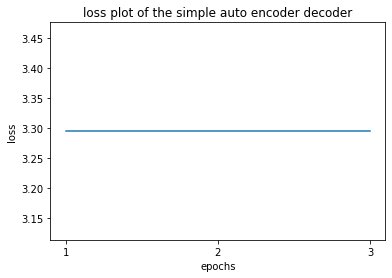

In [ ]:
plt.plot(np.arange(1, len(total_lost_simple_model) + 1), total_lost_simple_model)
plt.title('loss plot of the simple auto encoder decoder')
plt.xticks(np.arange(1,1 + len(total_lost_simple_model)))
plt.xlabel('epochs')
plt.ylabel('loss')

In [56]:
# tranining the model

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss().to(device) 
n_epochs = 10
total_images = len(data_loader) * batch_size
total_lost_model = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    batch_id = 0
    #Training
    for data in data_loader:
        images, _ = data
        images_cropped = images[:,:,:,:64]
        images = images.to(device)
        images_cropped = images_cropped.to(device)
        optimizer.zero_grad()
        outputs = model(images_cropped)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if batch_id % 50 == 0:
          print(batch_id, 'batches computed')
        if batch_id > 500:
          break

        batch_id += 1

    train_loss = train_loss/len(data_loader)
    total_lost_model.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 1 	Training Loss: 2.631720
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 2 	Training Loss: 2.610503
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 3 	Training Loss: 2.598226
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 bat

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cl

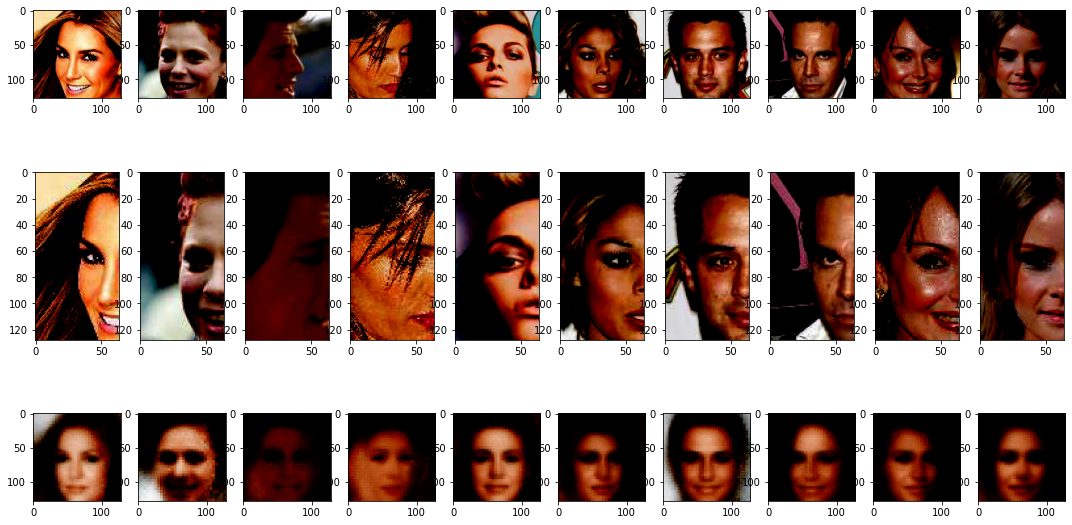

In [57]:
num_actual = next(iter(data_loader))[0]

original_photos = num_actual
cropped_photos = original_photos[:,:,:,:64]

with torch.no_grad():

  output = model(num_actual[:,:,:,:64].to(device))
  
fig, axes = plt.subplots(3, 10)

fig.set_size_inches(18.5, 10.5)

output = output.to(device)

axes[0][0].imshow(original_photos[0].permute(1, 2, 0))
axes[1][0].imshow(cropped_photos[0].permute(1, 2, 0))
axes[2][0].imshow(output[0].permute(1, 2, 0))

axes[0][1].imshow(original_photos[1].permute(1, 2, 0))
axes[1][1].imshow(cropped_photos[1].permute(1, 2, 0))
axes[2][1].imshow(output[1].permute(1, 2, 0))

axes[0][2].imshow(original_photos[2].permute(1, 2, 0))
axes[1][2].imshow(cropped_photos[2].permute(1, 2, 0))
axes[2][2].imshow(output[2].permute(1, 2, 0))

axes[0][3].imshow(original_photos[3].permute(1, 2, 0))
axes[1][3].imshow(cropped_photos[3].permute(1, 2, 0))
axes[2][3].imshow(output[3].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][5].imshow(original_photos[5].permute(1, 2, 0))
axes[1][5].imshow(cropped_photos[5].permute(1, 2, 0))
axes[2][5].imshow(output[5].permute(1, 2, 0))

axes[0][6].imshow(original_photos[6].permute(1, 2, 0))
axes[1][6].imshow(cropped_photos[6].permute(1, 2, 0))
axes[2][6].imshow(output[6].permute(1, 2, 0))

axes[0][7].imshow(original_photos[7].permute(1, 2, 0))
axes[1][7].imshow(cropped_photos[7].permute(1, 2, 0))
axes[2][7].imshow(output[7].permute(1, 2, 0))

axes[0][8].imshow(original_photos[8].permute(1, 2, 0))
axes[1][8].imshow(cropped_photos[8].permute(1, 2, 0))
axes[2][8].imshow(output[8].permute(1, 2, 0))

axes[0][9].imshow(original_photos[9].permute(1, 2, 0))
axes[1][9].imshow(cropped_photos[9].permute(1, 2, 0))
axes[2][9].imshow(output[9].permute(1, 2, 0))


Text(0, 0.5, 'loss')

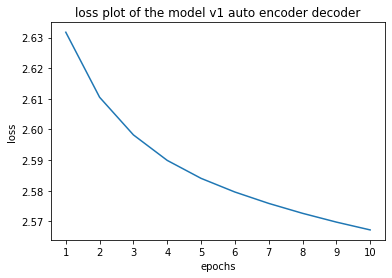

In [59]:
plt.plot(np.arange(1, len(total_lost_model) + 1), total_lost_model)
plt.title('loss plot of the model v1 auto encoder decoder')
plt.xticks(np.arange(1,1 + len(total_lost_model)))
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
# tranining the more complicated model

optimizer = torch.optim.Adam(model_v2.parameters(), lr=0.001)
criterion = nn.MSELoss().to(device) 
n_epochs = 3
total_images = len(data_loader) * batch_size
total_lost_modelv2 = []
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    batch_id = 0
    #Training
    for data in data_loader:
        images, _ = data
        images_cropped = images[:,:,:,:64]
        images = images.to(device)
        images_cropped = images_cropped.to(device)
        optimizer.zero_grad()
        outputs = model_v2(images_cropped)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        if batch_id % 50 == 0:
          print(batch_id, 'batches computed')
        if batch_id > 500:
          break

        batch_id += 1

    train_loss = train_loss/len(data_loader_cropped)
    total_lost_modelv2.append(train_loss)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 1 	Training Loss: 3.587533
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 2 	Training Loss: 3.191590
0 batches computed
50 batches computed
100 batches computed
150 batches computed
200 batches computed
250 batches computed
300 batches computed
350 batches computed
400 batches computed
450 batches computed
500 batches computed
Epoch: 3 	Training Loss: 3.076447


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cl

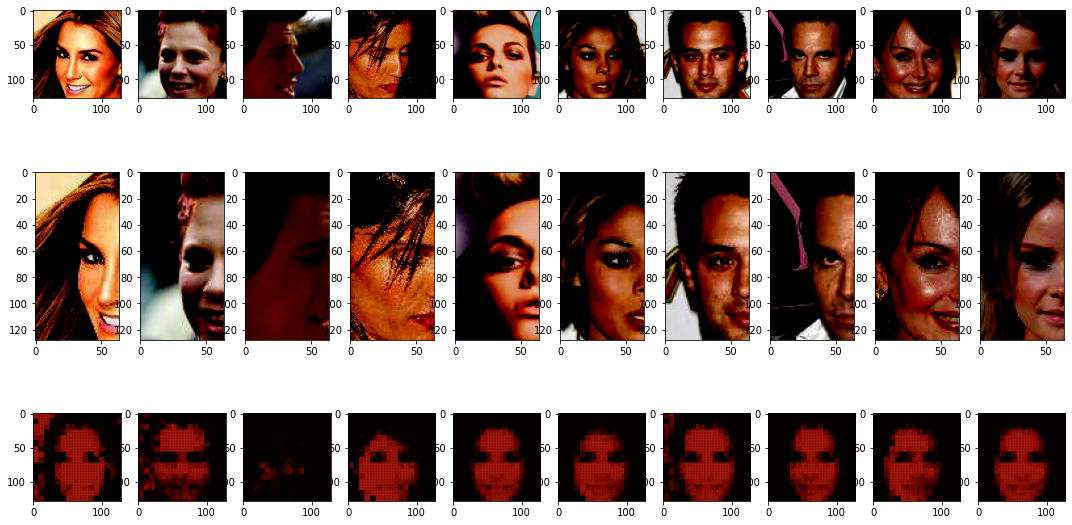

In [ ]:
num_actual = next(iter(data_loader))[0]

original_photos = num_actual
cropped_photos = original_photos[:,:,:,:64]

with torch.no_grad():

  output = model_v2(num_actual[:,:,:,:64].to(device))
  
fig, axes = plt.subplots(3, 10)

fig.set_size_inches(18.5, 10.5)

output = output.to(device)

axes[0][0].imshow(original_photos[0].permute(1, 2, 0))
axes[1][0].imshow(cropped_photos[0].permute(1, 2, 0))
axes[2][0].imshow(output[0].permute(1, 2, 0))

axes[0][1].imshow(original_photos[1].permute(1, 2, 0))
axes[1][1].imshow(cropped_photos[1].permute(1, 2, 0))
axes[2][1].imshow(output[1].permute(1, 2, 0))

axes[0][2].imshow(original_photos[2].permute(1, 2, 0))
axes[1][2].imshow(cropped_photos[2].permute(1, 2, 0))
axes[2][2].imshow(output[2].permute(1, 2, 0))

axes[0][3].imshow(original_photos[3].permute(1, 2, 0))
axes[1][3].imshow(cropped_photos[3].permute(1, 2, 0))
axes[2][3].imshow(output[3].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][4].imshow(original_photos[4].permute(1, 2, 0))
axes[1][4].imshow(cropped_photos[4].permute(1, 2, 0))
axes[2][4].imshow(output[4].permute(1, 2, 0))

axes[0][5].imshow(original_photos[5].permute(1, 2, 0))
axes[1][5].imshow(cropped_photos[5].permute(1, 2, 0))
axes[2][5].imshow(output[5].permute(1, 2, 0))

axes[0][6].imshow(original_photos[6].permute(1, 2, 0))
axes[1][6].imshow(cropped_photos[6].permute(1, 2, 0))
axes[2][6].imshow(output[6].permute(1, 2, 0))

axes[0][7].imshow(original_photos[7].permute(1, 2, 0))
axes[1][7].imshow(cropped_photos[7].permute(1, 2, 0))
axes[2][7].imshow(output[7].permute(1, 2, 0))

axes[0][8].imshow(original_photos[8].permute(1, 2, 0))
axes[1][8].imshow(cropped_photos[8].permute(1, 2, 0))
axes[2][8].imshow(output[8].permute(1, 2, 0))

axes[0][9].imshow(original_photos[9].permute(1, 2, 0))
axes[1][9].imshow(cropped_photos[9].permute(1, 2, 0))
axes[2][9].imshow(output[9].permute(1, 2, 0))


Text(0, 0.5, 'loss')

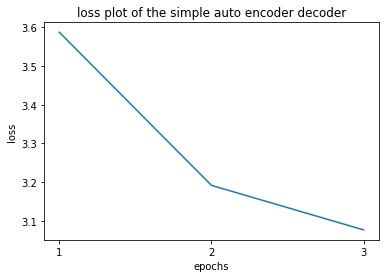

In [ ]:
plt.plot(np.arange(1, len(total_lost_modelv2) + 1), total_lost_modelv2)
plt.title('loss plot of the simple auto encoder decoder')
plt.xticks(np.arange(1,1 + len(total_lost_modelv2)))
plt.xlabel('epochs')
plt.ylabel('loss')

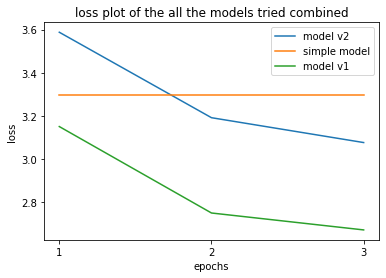

In [ ]:
plt.plot(np.arange(1, len(total_lost_modelv2) + 1), total_lost_modelv2, label='model v2')
plt.plot(np.arange(1, len(total_lost_simple_model) + 1), total_lost_simple_model, label='simple model')
plt.plot(np.arange(1, len(total_lost_model) + 1), total_lost_model, label='model v1')

plt.title('loss plot of the all the models tried combined')
plt.xticks(np.arange(1,1 + len(total_lost_modelv2)))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()